## Amazon Review Data : Data Exploration

### Setup spark

In [11]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

In [12]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "2g") \
	.config("spark.executor.memory", "2g") \
    .config('spark.executor.instances', 7) \
	.appName("Amazon Reviews") \
	.getOrCreate()

In [13]:
sqlContext = SQLContext(sc)

## Read Data

### Get files

In [23]:

# df = sc.read.csv("amazon_reviews_us_Gift_Card_v1_00.tsv", sep="\t", header=True, inferSchema=True)

In [18]:
#######################################################################################
############## change to get to my folder: uci150/clin6/amazon_data ###################
#######################################################################################
path = "amazon_data"

In [19]:
def read(path):
    """
    Method that loads data file as df
    Takes in 1 parameter: path
    """
    return sc.read.csv(path, sep = "\t", header = True, inferSchema = True)

def get_path(file):
    """
    Method to create path
    Takes in 1 parameter: file name
    """
    return "amazon_data/%s" % file

In [20]:
dir = os.listdir(path)
files = [f for f in dir if os.path.isfile(os.path.join(path, f))]

FileNotFoundError: [Errno 2] No such file or directory: 'amazon_data'

In [17]:
def get_df(files):
    """
    Method that combines files into 1 big df
    Takes in 1 parameter: list of file names
    """
    df = read(get_path(files[0]))
    n = len(files)
    for i in range(1, n):
        data = read(get_path(files[i]))
        df = df.union(data)
    return df

### Get df

In [24]:
df = get_df(files)
sqlContext.registerDataFrameAsTable(df, "df")

# Data Exploration Start
* Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.

In [25]:
### Show how our data looks like
df.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   24371595|R27ZP1F1CD0C3Y|B004LLIL5A|     346014806|Amazon eGift Card...|       Gift Card|          5|            0|          0|   N|                Y|          Five Stars|Great birthday gi...|2015-08-31 00:00:00|
|         US|   42489718| RJ7RSBCHUDNNE|B004LLIKVU|     473048287|Amazon.com eGift ...| 

In [26]:
### Total number of observations
num_rows = df.count()
print('There is a total of %d observations' % num_rows)

There is a total of 149086 observations


In [27]:
### Get columns
columns = df.columns
print('Columns:')
print(columns)

Columns:
['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']


In [28]:
### Get number of columns
num_cols = len(columns)
print('There is a total of %d columns' % num_cols)

There is a total of 15 columns


In [37]:
### removing repetitive/unnecessary information
df = df.select([col for col in df.columns if col not in ['marketplace', 'vine']])

### var after updated df
columns = df.columns
num_cols = len(columns)

In [38]:
### Get number of missing values for each column
for i in range(num_cols):
    missing = df.filter(df[columns[i]].isNull()).count()
    print("'%s' column has %d missing values" % (columns[i], missing))

'customer_id' column has 0 missing values
'review_id' column has 0 missing values
'product_id' column has 0 missing values
'product_parent' column has 0 missing values
'product_title' column has 0 missing values
'product_category' column has 0 missing values
'star_rating' column has 0 missing values
'helpful_votes' column has 0 missing values
'total_votes' column has 0 missing values
'verified_purchase' column has 0 missing values
'review_headline' column has 0 missing values
'review_body' column has 6 missing values
'review_date' column has 5 missing values


In [39]:
data_types = df.dtypes
for i in range(num_cols):
    print("'%s' column is of type '%s'" % (data_types[i][0], data_types[i][1]))

'customer_id' column is of type 'int'
'review_id' column is of type 'string'
'product_id' column is of type 'string'
'product_parent' column is of type 'int'
'product_title' column is of type 'string'
'product_category' column is of type 'string'
'star_rating' column is of type 'int'
'helpful_votes' column is of type 'int'
'total_votes' column is of type 'int'
'verified_purchase' column is of type 'string'
'review_headline' column is of type 'string'
'review_body' column is of type 'string'
'review_date' column is of type 'timestamp'


In [40]:
### Show data distributions
df.describe().show()

+-------+--------------------+--------------+----------+--------------------+--------------------+----------------+------------------+-------------------+------------------+-----------------+--------------------+--------------------+
|summary|         customer_id|     review_id|product_id|      product_parent|       product_title|product_category|       star_rating|      helpful_votes|       total_votes|verified_purchase|     review_headline|         review_body|
+-------+--------------------+--------------+----------+--------------------+--------------------+----------------+------------------+-------------------+------------------+-----------------+--------------------+--------------------+
|  count|              149086|        149086|    149086|              149086|              149086|          149086|            149086|             149086|            149086|           149086|              149086|              149080|
|   mean| 2.628253678963149E7|          null|      null| 5.40685

In [41]:
### Check for duplicates
duplicate_rows = df.groupBy(columns).count().where('count > 1')
duplicate_rows.show()

+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+-----------------+---------------+-----------+-----------+-----+
|customer_id|review_id|product_id|product_parent|product_title|product_category|star_rating|helpful_votes|total_votes|verified_purchase|review_headline|review_body|review_date|count|
+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+-----------------+---------------+-----------+-----------+-----+
+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+-----------------+---------------+-----------+-----------+-----+



# Plot
reference:
https://plotly.com/python/v3/apache-spark/

In [42]:
### Import libraries to plot
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import iplot
py.init_notebook_mode(connected = True)

from pyspark.sql.functions import col

# Methods to plot

In [43]:
def plot(title, data):
    """
    Helper method to plot
    Takes in two paramaters: title, data
    """
    layout = go.Layout(title = title)                       # Create layout
    fig = go.Figure(data = data, layout = layout)           # Create figure
    iplot(fig)                                              # Plot figure

In [44]:
def plot_histogram(df, i):
    """
    Method to plot histogram of column
    Takes in two parameters: df, column index
    """
    column_name = columns[i]                                # Get column name and data
    data = [go.Histogram(x = df.select(col(column_name)).rdd.flatMap(lambda x: x).collect())]
    title = 'Histogram of %s' % columns[i]                  # Set title
    plot(title, data)                                       # Use helper method to plot

In [45]:
def plot_piechart(df, i):
    """
    Method to plot pie chart of column
    Takes in two parameters: df, column index
    """
    column_name = columns[i]                                                      # Get column name
    counts = df.select(col(column_name)).groupBy(column_name).count().toPandas()  # Get counts
    data = [go.Pie(labels = counts[column_name], values = counts['count'])]       # Get data
    title = 'Pie Chart of %s' % columns[i]                                        # Set title
    plot(title, data)                                       # Use helper method to plot

In [46]:
def plot_barplot(df, i):
    """
    Method to plot bar plot of column
    Takes in one parameter: column index
    """
    column_name = columns[i]                                                      # Get column name 
    counts = df.select(col(column_name)).groupBy(column_name).count().toPandas()  # Get counts
    data = [go.Bar(x = counts[column_name], y = counts['count'])]                 # Get data    
    title = 'Bar Plot of %s' % columns[i]                                         # Set title
    plot(title, data)                                       # Use helper method to plot

In [47]:
def plot_boxplot(df, i):
    """
    Method to plot box plot of column
    Takes in two parameters: df, column index
    """
    column_name = columns[i]                                # Get column name and data
    data = [go.Box(y = df.select(column_name).rdd.flatMap(lambda x: x).collect())]
    title = 'Box plot of %s' % column_name                  # Set title
    plot(title, data)                                       # Use helper method to plot

In [48]:
def plot_boxplot_no_outliers(df, i):
    """
    Method to plot box plot of column after removing outliers
    Takes in two parameters: df, column index
    """
    column_name = columns[i]                                             # Get column name
    quartiles = df.approxQuantile(column_name, [0.25, 0.75], 0.01)       # Calculate quartiles
    q1 = quartiles[0]
    q3 = quartiles[1]
    iqr = q3 - q1                                                        # Calculate iqr
    lower_bound = q1 - 1.5 * iqr                                         # Define bounds
    upper_bound = q3 + 1.5 * iqr
    
    # Remove outliers
    column_data_no_outliers = df.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))
    
    # Filter data
    data = [go.Box(y = column_data_no_outliers.select(column_name).rdd.flatMap(lambda x: x).collect())]
    
    title = 'Box plot of %s (Outliers Removed)' % columns[i]             # Set title
    plot(title, data)                                                    # Use helper method to plot

## Analysis

In [53]:
### CHANGE COLUMN INDEX TO PLOT
i = 7
plot_histogram(df, i)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 82.0 failed 1 times, most recent failure: Lost task 2.0 in stage 82.0 (TID 741, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 175, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 175, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


* There are clearly noticeable high outliers, which conceal the visibility of the distribution
* Lets look at a boxplot

In [50]:
### CHANGE COLUMN INDEX TO PLOT
i = 7
plot_boxplot(df, i)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 76.0 failed 1 times, most recent failure: Lost task 0.0 in stage 76.0 (TID 505, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 175, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 175, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


* Indeed we see many high outliers

In [55]:
### CHANGE COLUMN INDEX TO PLOT
i = 7
plot_boxplot_no_outliers(df, i)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 87.0 failed 1 times, most recent failure: Lost task 6.0 in stage 87.0 (TID 971, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 175, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 175, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


* Outliers removed box plot, we see most reviews have no votes

In [54]:
### CHANGE COLUMN INDEX TO PLOT
i = 6
plot_barplot(df, i)

* Majority of ratings given are 5 stars
* Second most given rating is 1 but still much less than 5
* Increased ratings from 2 to 5 stars

# Look at category proportions

In [56]:
### CHANGE COLUMN INDEX TO PLOT
i = 6
plot_piechart(df, i)

In [59]:
from pyspark.sql.functions import year, substring
import matplotlib.pyplot as plt


def plot_purchase_counts(df, df_name, target_year):
    """
    Plot the purchase counts for a given DataFrame and year.

    Args:
    - df: The DataFrame containing the review data.
    - target_year: The year for which purchase counts will be plotted.
    - df_name: The name of the DataFrame.

    Returns:
    - None
    """
    # Filter the DataFrame to include only rows from the specified year
    df_year = df.filter(year(df['review_date']) == target_year)

    # Extract the month from the 'review_date' column
    df_year = df_year.withColumn('review_month', substring(df_year['review_date'], 6, 2))

    # Count the number of purchases for each month
    purchase_counts = df_year.groupby('review_month').count().orderBy('review_month')

    # Plot the counts using a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(purchase_counts.toPandas()['review_month'], purchase_counts.toPandas()['count'])
    plt.title(f'Purchase Counts for {df_name} Year {target_year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Purchases')
    plt.show()

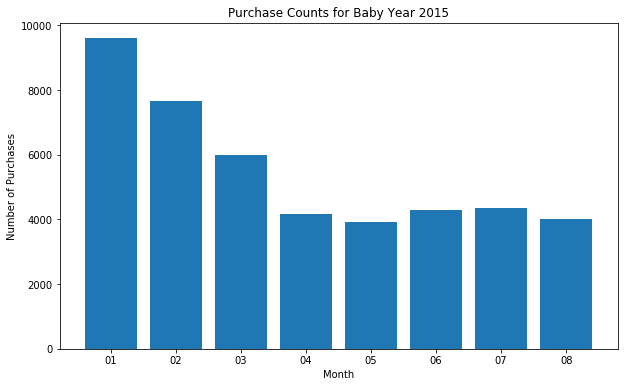

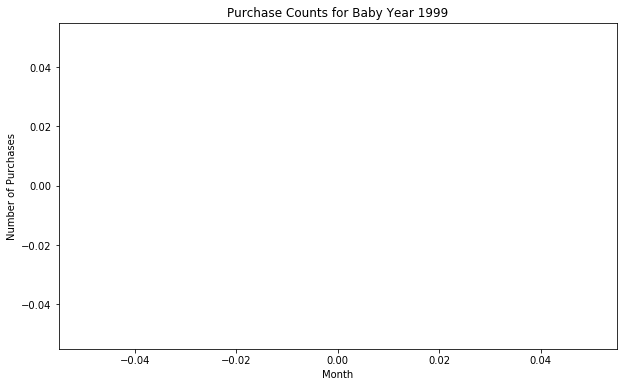

In [60]:
plot_purchase_counts(df, "Baby", 2015)
plot_purchase_counts(df, "Baby", 1999)